Entrainement de mon premier GAN en suivant le tutoriel https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
<br/>
On transpose le GAN pour qu'il génère des nombres aléatoires 

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader



In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [8]:
# Root directory for dataset
dataroot = "../Data/MNIST/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 20

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


data = pd.read_csv(dataroot + 'train.csv')
data_test = pd.read_csv(dataroot + 'test.csv')
data_train, data_val = train_test_split(data ,test_size=0.1, random_state=10, shuffle=True)


In [10]:


###################################################################################
'''
Pour la prochaine fois : manière assez clair de transformer les rawdata, séparer x et y et tout convertir en torch dès le init. 
Et dans le len / getitem on met presque rien, sauf la fontion transform de pytorch
 '''

class MNISTDataset(Dataset):
    def __init__(self, data,transform=None, is_test=False):
        super().__init__()
        self.dataset = data
        self.transform=transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset.iloc[index].to_numpy()
        if self.is_test:
            label = None                            #il faut dire ce qui est le Y et ce qui est le X pour chaque ligne 
            image = data.reshape(28, 28)
        else:
            label = data[0]                             #il faut dire ce qui est le Y et ce qui est le X pour chaque ligne 
            image = data[1:].reshape(28, 28)
        if self.transform is not None:
            image = self.transform(image.astype(np.float32))
        return image, label
        
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

In [11]:
#on crée une classe enfant de la classe Dataset de torch, qui permet de convertir en tenseur
Tdata_train = MNISTDataset(data_train, transform= transform)
Tdata_val = MNISTDataset(data_val,  transform= transform)
Tdata_test = MNISTDataset(data_test, transform= transform, is_test=True)


#mise en forme de batches des données (DataLoader)
torch.manual_seed(1)
DL_train = DataLoader(Tdata_train,batch_size,shuffle=True)
DL_val = DataLoader(Tdata_val,batch_size,shuffle=True)

In [ ]:
Tdata_train[0][1]

torch.Size([32, 1, 28, 28])


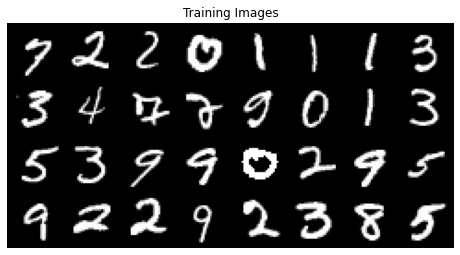

In [16]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = Tdata_train
# Create the dataloader
dataloader = DL_train
# Decide which device we want to run on
device = "cpu"
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
print(real_batch[0].shape)

In [20]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
import HD_DL_tools as HD

choose_parameters_Conv(28,16)


w


In [110]:
# Generator Code

# IL DOIT Y AVOIR UNE FONCTIONNALITÉ DE PYTORCH QUI 
# ETANT DONNÉ UNE (ARCHITECTURE DE RESEAU, UN TAILLE D'INPUT VOULUE ET UNE TAILLE D'OUTPUT VOULUE) :
# PROPOSE DES PARAMETRES POUR LES SOUS COUCHES DE RESEAU (KERNEL, STRIDE, PADDING, ETC) QUI FONT QUE L'INPUT ET L'OUTPUT AIENT LA TAILLE VOULUE

# output de conv transposed :
# output ​= (input​−1)×stride − 2×padding + dilation×(kernel_size−1) + output_padding + 1
#un moyen que input = output --> stride =1 , 2*padding = dilat*(kernel-1)
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( in_channels= nz, out_channels= ngf * 8, kernel_size = 4, stride = 1, padding= 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            #nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 4, 2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            #nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.ConvTranspose2d( ngf * 2, ngf, 5, 1, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 5, 1, 2, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [75]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nn.Conv2d(nc, ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 3, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 3, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [142]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#on affiche les paramètres du modèle


# Create the Discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

for param in netG.parameters():
    print(param.size())



torch.Size([20, 256, 4, 4])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 4, 4])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 4, 4])
torch.Size([64])
torch.Size([64])
torch.Size([64, 32, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 5, 5])


In [70]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [112]:
#pour modifier l'architecture du génerateur 
print(fixed_noise.shape)
img_list = netG(fixed_noise).detach().cpu()
print(img_list.shape)


torch.Size([32, 20, 1, 1])
torch.Size([32, 1, 28, 28])


In [ ]:
#pour modifier l'architecture du discriminateur
type(img_list)
print(img_list.shape)
probas = netD(img_list)

In [ ]:
# Regardons les images générées avant l'entrainement... c'est du bruit normalement
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images générées avant l'entrainement")
plt.imshow(np.transpose(vutils.make_grid(img_list, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1